## Here, we used new training data that has randomized dispersions and phases to try and predict the dispersion as well as the phase.


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

## Made new training data with E_0 and mstar fixed. 

In [2]:
#Load the training data
subset = 5 #every 10 mV
start = 50 # for starting at -300mV

peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
energy_names2 = energy_names[start::subset]
energy_names3 = energy_names[start::1]

col_names2 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names + locs_names + width_names + prom_names
col_names2a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names[1:] + locs_names + width_names + prom_names[1:]

col_names1 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names

#col_names_both = col_names2 + energy_names2
col_names_both = col_names2a + energy_names2
col_names_a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names3

data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071318_v11_E0Mfixed_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071318_v11_E0Mfixed_peakinfo.csv', header = None, names = col_names2)
save_data = True


data = data2.join(data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1), how = 'left')
data = data[col_names_both]

data1a = data1[col_names_a]
data2a = data2[col_names2a]

X1 = data1a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y1 = data1a[['deltaI', 'deltaR', 'alpha']]

X2 = data2a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y2 = data2a[['deltaI', 'deltaR', 'alpha']]

X = data.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y = data[['deltaI', 'deltaR', 'alpha']]

ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

data1.head()

,deltaI,deltaR,E_0,mstar,alpha,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.44839,0.378,-8.6764,0.139850,0.144510,0.151150,0.160380,0.172220,...,0.89659,0.89788,0.90143,0.90678,0.91389,0.92291,0.93388,0.94617,0.95993,0.97524
1,0.09754,-1.133300,0.44839,0.378,-5.3511,0.027981,0.028872,0.029885,0.031658,0.033707,...,0.48410,0.43431,0.39291,0.36025,0.33074,0.30783,0.28731,0.27008,0.25658,0.24315
2,0.15761,-0.046193,0.44839,0.378,-6.9972,0.371970,0.390420,0.414270,0.444340,0.481940,...,1.04140,1.03920,1.03740,1.03560,1.03400,1.03240,1.03100,1.02970,1.02840,1.02690
3,0.14189,-0.908300,0.44839,0.378,-5.4051,0.030740,0.032138,0.033764,0.036101,0.038826,...,0.36009,0.33883,0.32069,0.30525,0.29294,0.28202,0.27324,0.26729,0.26151,0.25833
4,0.65574,-1.514700,0.44839,0.378,-8.2126,0.076420,0.078793,0.082203,0.086934,0.093088,...,0.69881,0.68307,0.67061,0.66104,0.65431,0.65011,0.64889,0.65044,0.65450,0.66149


## Statsmodels OLS

### spec points

 
RMSE on test data: 1.280904530874903 for  Delta I
R^2 Score on test data: -18.541041864901196 for Delta I
 
RMSE on test data: 1.7274669661211735 for  Delta R
R^2 Score on test data: -13.77309014494596 for Delta R
 
RMSE on test data: 1.7642964393199412 for  alpha
R^2 Score on test data: 0.6229933515965456 for alpha


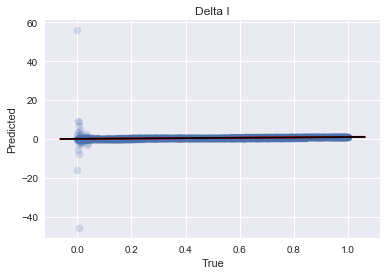

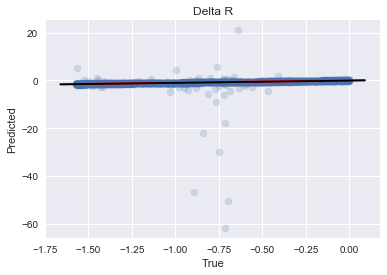

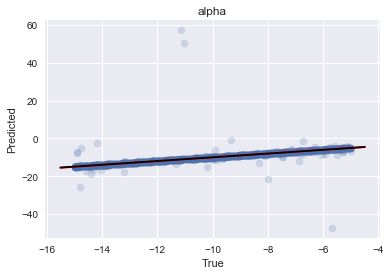

In [3]:
#Initialize and fit OLS model for deltaI 
E0M_model_OLS_I_sp = sm.OLS(Y1_train['deltaI'], X1_train)
E0M_model_OLS_R_sp = sm.OLS(Y1_train['deltaR'], X1_train)
E0M_model_OLS_alpha_sp = sm.OLS(Y1_train['alpha'], X1_train)

E0M_results_OLS_I_sp = E0M_model_OLS_I_sp.fit()
E0M_results_OLS_R_sp = E0M_model_OLS_R_sp.fit()
E0M_results_OLS_alpha_sp = E0M_model_OLS_alpha_sp.fit()

#Make predictions on testing data
E0M_predictions_OLS_I_sp = E0M_results_OLS_I_sp.predict(X1_test) # make the predictions by the model
E0M_predictions_OLS_R_sp = E0M_results_OLS_R_sp.predict(X1_test)
E0M_predictions_OLS_alpha_sp = E0M_results_OLS_alpha_sp.predict(X1_test)

E0M_scores_OLS = [r2_score(Y1_test['deltaI'], E0M_predictions_OLS_I_sp), 
                 r2_score(Y1_test['deltaR'], E0M_predictions_OLS_R_sp),  
                 r2_score(Y1_test['alpha'], E0M_predictions_OLS_alpha_sp) ]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y1_test['deltaI'], E0M_predictions_OLS_I_sp,'Delta I')
#ylim([-1,5])
plotSummary(Y1_test['deltaR'], E0M_predictions_OLS_R_sp, 'Delta R')
plotSummary(Y1_test['alpha'], E0M_predictions_OLS_alpha_sp, 'alpha')



### peak info

 
RMSE on test data: 0.1476047410428882 for  Delta I
R^2 Score on test data: 0.7405134775453543 for Delta I
 
RMSE on test data: 0.36771331457945244 for  Delta R
R^2 Score on test data: 0.3306233532692756 for Delta R
 
RMSE on test data: 1.8455494053703676 for  alpha
R^2 Score on test data: 0.5874683772339895 for alpha


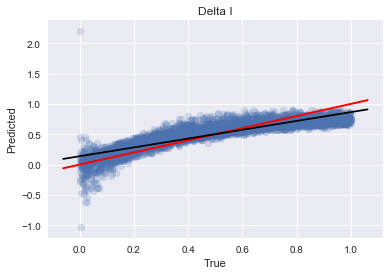

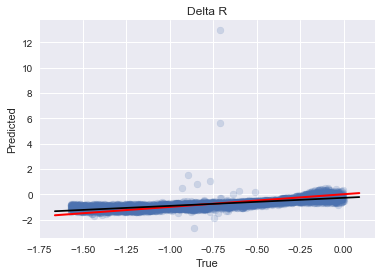

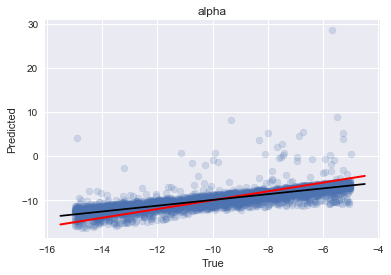

In [4]:
#Initialize and fit OLS model for deltaI 
E0M_model_OLS_I_pi = sm.OLS(Y2_train['deltaI'], X2_train)
E0M_model_OLS_R_pi = sm.OLS(Y2_train['deltaR'], X2_train)
E0M_model_OLS_alpha_pi = sm.OLS(Y2_train['alpha'], X2_train)

E0M_results_OLS_I_pi = E0M_model_OLS_I_pi.fit()
E0M_results_OLS_R_pi = E0M_model_OLS_R_pi.fit()
E0M_results_OLS_alpha_pi = E0M_model_OLS_alpha_pi.fit()

#Make predictions on testing data
E0M_predictions_OLS_I_pi = E0M_results_OLS_I_pi.predict(X2_test) # make the predictions by the model
E0M_predictions_OLS_R_pi = E0M_results_OLS_R_pi.predict(X2_test)
E0M_predictions_OLS_alpha_pi = E0M_results_OLS_alpha_pi.predict(X2_test)

E0M_scores_OLS_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_OLS_I_pi), 
                 r2_score(Y2_test['deltaR'], E0M_predictions_OLS_R_pi), 
                 r2_score(Y2_test['alpha'], E0M_predictions_OLS_alpha_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y2_test['deltaI'], E0M_predictions_OLS_I_pi,'Delta I')
#ylim([-1,5])
plotSummary(Y2_test['deltaR'], E0M_predictions_OLS_R_pi, 'Delta R')

plotSummary(Y2_test['alpha'], E0M_predictions_OLS_alpha_pi, 'alpha')



### spec points and peak info

 
RMSE on test data: 0.11842667868672115 for  Delta I
R^2 Score on test data: 0.8329627657377949 for Delta I
 
RMSE on test data: 0.1350606251254504 for  Delta R
R^2 Score on test data: 0.9096955074662656 for Delta R
 
RMSE on test data: 0.5422282484263949 for  alpha
R^2 Score on test data: 0.9643901477161072 for alpha


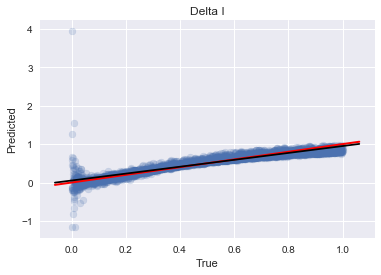

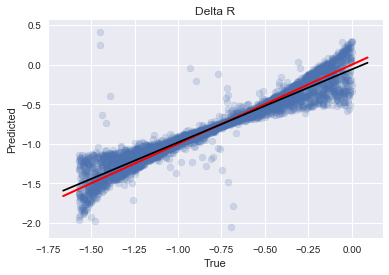

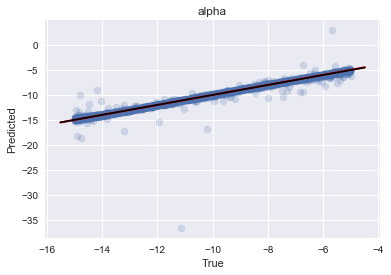

In [5]:
#Initialize and fit OLS model for deltaI 
E0M_model_OLS_I_both = sm.OLS(Y_train['deltaI'], X_train)
E0M_model_OLS_R_both = sm.OLS(Y_train['deltaR'], X_train)
E0M_model_OLS_alpha_both = sm.OLS(Y_train['alpha'], X_train)

E0M_results_OLS_I_both = E0M_model_OLS_I_both.fit()
E0M_results_OLS_R_both = E0M_model_OLS_R_both.fit()
E0M_results_OLS_alpha_both = E0M_model_OLS_alpha_both.fit()

#Make predictions on testing data
E0M_predictions_OLS_I_both = E0M_results_OLS_I_both.predict(X_test) # make the predictions by the model
E0M_predictions_OLS_R_both = E0M_results_OLS_R_both.predict(X_test)
E0M_predictions_OLS_alpha_both = E0M_results_OLS_alpha_both.predict(X_test)

E0M_scores_OLS_both = [r2_score(Y_test['deltaI'], E0M_predictions_OLS_I_both), 
                 r2_score(Y_test['deltaR'], E0M_predictions_OLS_R_both), 
                 r2_score(Y_test['alpha'], E0M_predictions_OLS_alpha_both)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], E0M_predictions_OLS_I_both,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], E0M_predictions_OLS_R_both, 'Delta R')

plotSummary(Y_test['alpha'], E0M_predictions_OLS_alpha_both, 'alpha')



## Decision Tree

### spec points

 
RMSE on test data: 0.06106047839147478 for  deltaI Depth 60
R^2 Score on test data: 0.9555947216691656 for deltaI Depth 60
 
RMSE on test data: 0.07432785024631401 for  deltaR Depth 60
R^2 Score on test data: 0.9726501474329582 for deltaR Depth 60
 
RMSE on test data: 0.3247937488567947 for  alpha
R^2 Score on test data: 0.9872232258602134 for alpha


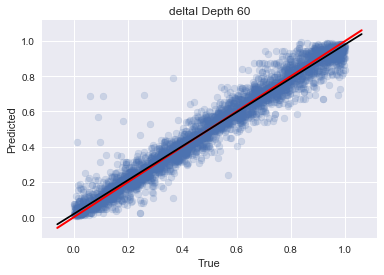

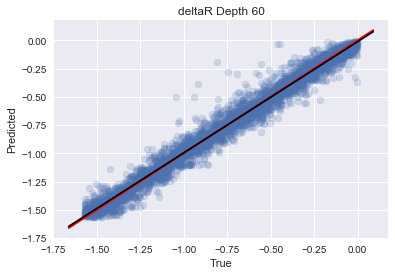

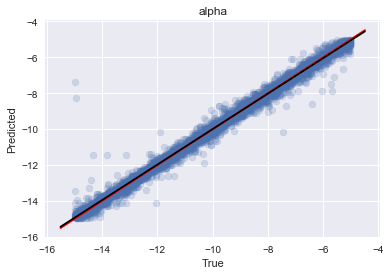

In [6]:
#Initialize the model
rs = 42
E0M_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0M_regr_DT_sp = E0M_regr_DT_sp.fit(X1_train, Y1_train)


#Use model to predict
E0M_predictions_DT_sp = E0M_regr_DT_sp.predict(X1_test)

E0M_scores_DT = [r2_score(Y1_test['deltaI'], E0M_predictions_DT_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0M_predictions_DT_sp[:,1]), 
                r2_score(Y1_test['alpha'], E0M_predictions_DT_sp[:,2]) ]

#Plot results
plotSummary(Y1_test['deltaI'], E0M_predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], E0M_predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y1_test['alpha'], E0M_predictions_DT_sp[:,2], 'alpha')



### peak info

 
RMSE on test data: 0.04956539941228182 for  deltaI Depth 60
R^2 Score on test data: 0.9707401960527227 for deltaI Depth 60
 
RMSE on test data: 0.06869135585514022 for  deltaR Depth 60
R^2 Score on test data: 0.9766409044646913 for deltaR Depth 60
 
RMSE on test data: 0.5288110516390245 for  alpha
R^2 Score on test data: 0.9661306439586831 for alpha


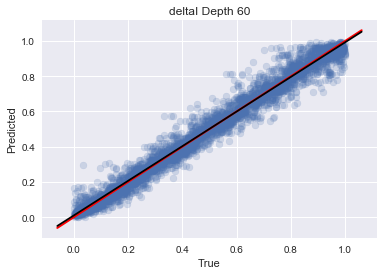

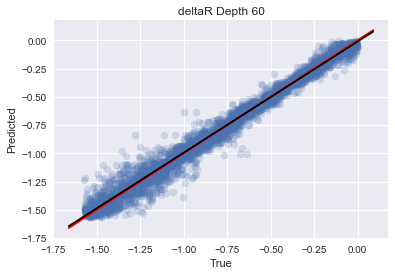

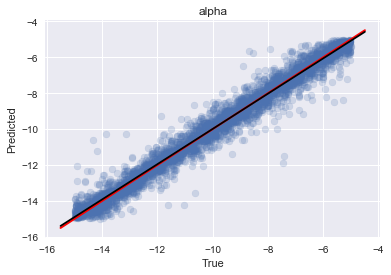

In [7]:

#Initialize the model
rs = 42
E0M_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0M_regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0M_predictions_DT_pi = E0M_regr_DT_pi.predict(X2_test)

E0M_scores_DT_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_DT_pi[:,0]), 
                r2_score(Y2_test['deltaR'], E0M_predictions_DT_pi[:,1]), 
                r2_score(Y2_test['alpha'], E0M_predictions_DT_pi[:,2])]

#Plot results
plotSummary(Y2_test['deltaI'], E0M_predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], E0M_predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

plotSummary(Y2_test['alpha'], E0M_predictions_DT_pi[:,2], 'alpha')

### spec points and peak info

 
RMSE on test data: 0.05897721175937534 for  deltaI Depth 60
R^2 Score on test data: 0.9585730781611619 for deltaI Depth 60
 
RMSE on test data: 0.07364715465835073 for  deltaR Depth 60
R^2 Score on test data: 0.9731487943566981 for deltaR Depth 60
 
RMSE on test data: 0.4001969861704258 for  alpha
R^2 Score on test data: 0.9806021533780047 for alpha


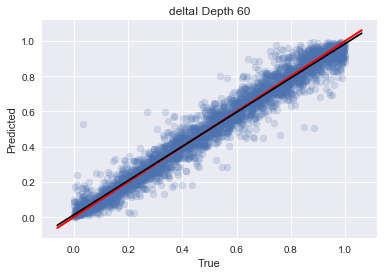

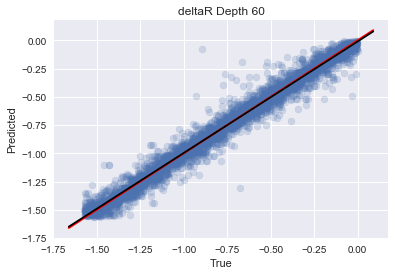

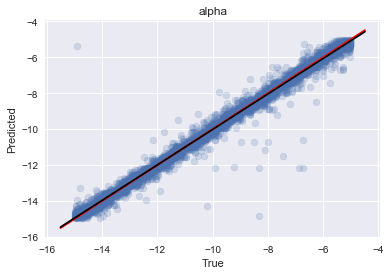

In [8]:
#Initialize the model
rs = 42
E0M_regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0M_regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0M_predictions_DT_both = E0M_regr_DT_both.predict(X_test)

E0M_scores_DT_both = [r2_score(Y_test['deltaI'], E0M_predictions_DT_both[:,0]), 
                r2_score(Y_test['deltaR'], E0M_predictions_DT_both[:,1]), 
                r2_score(Y_test['alpha'], E0M_predictions_DT_both[:,2])]

#Plot results
plotSummary(Y_test['deltaI'], E0M_predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], E0M_predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

plotSummary(Y_test['alpha'], E0M_predictions_DT_both[:,2], 'alpha')

## Random Forests

### spec points

 
RMSE on test data: 0.02329720051667916 for  deltaI 10
R^2 Score on test data: 0.9935356975676937 for deltaI 10
 
RMSE on test data: 0.025760338550928723 for  deltaR 10
R^2 Score on test data: 0.9967148517101533 for deltaR 10
 
RMSE on test data: 0.2182351340873849 for  alpha
R^2 Score on test data: 0.9942316017927242 for alpha


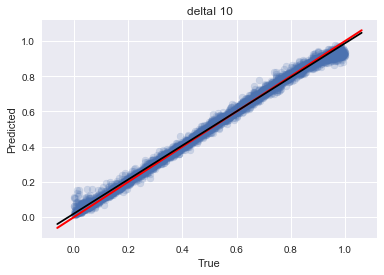

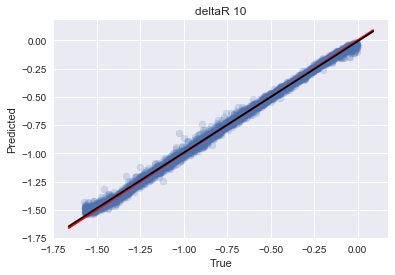

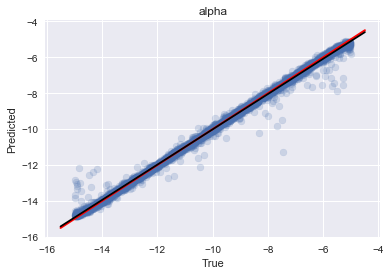

In [9]:
rs = 42
E0M_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0M_model_RF_sp = E0M_regr_RF_sp.fit(X1_train, Y1_train)

E0M_predictions_RF_sp = E0M_model_RF_sp.predict(X1_test)

E0M_scores_RF = [r2_score(Y1_test['deltaI'], E0M_predictions_RF_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0M_predictions_RF_sp[:,1]), 
                r2_score(Y1_test['alpha'], E0M_predictions_RF_sp[:,2])]

plotSummary(Y1_test['deltaI'], E0M_predictions_RF_sp[:,0], 'deltaI 10')
plotSummary(Y1_test['deltaR'], E0M_predictions_RF_sp[:,1], 'deltaR 10')
plotSummary(Y1_test['alpha'], E0M_predictions_RF_sp[:,2], 'alpha')



### peak info

 
RMSE on test data: 0.03473185852916789 for  deltaI 10
R^2 Score on test data: 0.9856328628301628 for deltaI 10
 
RMSE on test data: 0.05782831961092006 for  deltaR 10
R^2 Score on test data: 0.9834448549308259 for deltaR 10
 
RMSE on test data: 0.4459870288968684 for  alpha
R^2 Score on test data: 0.975909248413942 for alpha


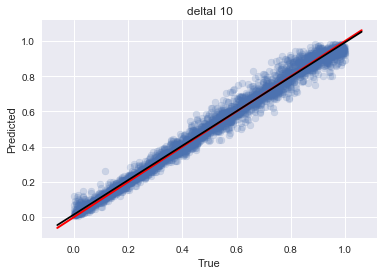

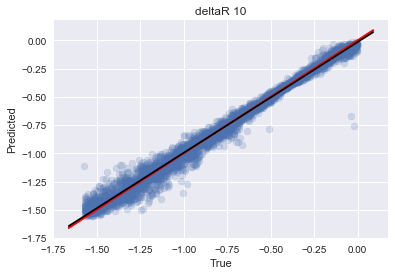

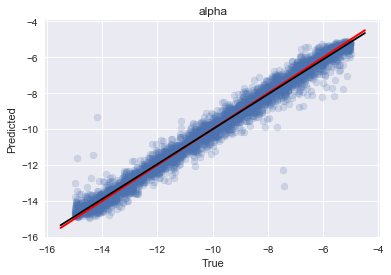

In [10]:
rs = 42
E0M_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0M_model_RF_pi = E0M_regr_RF_pi.fit(X2_train, Y2_train)

E0M_predictions_RF_pi = E0M_model_RF_pi.predict(X2_test)

E0M_scores_RF_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_RF_pi[:,0]), 
                   r2_score(Y2_test['deltaR'], E0M_predictions_RF_pi[:,1]), 
                   r2_score(Y2_test['alpha'], E0M_predictions_RF_pi[:,2])]

plotSummary(Y2_test['deltaI'], E0M_predictions_RF_pi[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], E0M_predictions_RF_pi[:,1], 'deltaR 10')
plotSummary(Y2_test['alpha'], E0M_predictions_RF_pi[:,2], 'alpha')

### spec points and peak info

 
RMSE on test data: 0.02328158084448642 for  deltaI 10
R^2 Score on test data: 0.9935443626806519 for deltaI 10
 
RMSE on test data: 0.028580959831984807 for  deltaR 10
R^2 Score on test data: 0.9959560529116739 for deltaR 10
 
RMSE on test data: 0.26177961186243226 for  alpha
R^2 Score on test data: 0.9917000106989676 for alpha


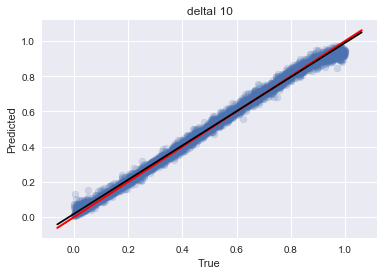

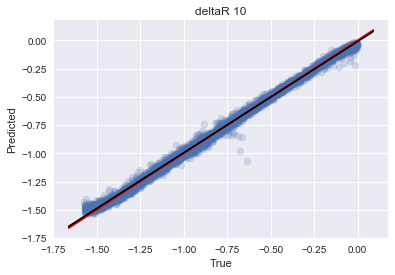

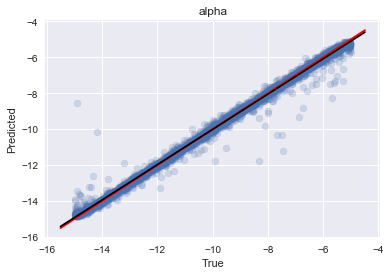

In [11]:
rs = 42
E0M_regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0M_model_RF_both = E0M_regr_RF_both.fit(X_train, Y_train)

E0M_predictions_RF_both = E0M_model_RF_both.predict(X_test)

E0M_scores_RF_both = [r2_score(Y_test['deltaI'], E0M_predictions_RF_both[:,0]), 
                   r2_score(Y_test['deltaR'], E0M_predictions_RF_both[:,1]), 
                   r2_score(Y_test['alpha'], E0M_predictions_RF_both[:,2])]

plotSummary(Y_test['deltaI'], E0M_predictions_RF_both[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], E0M_predictions_RF_both[:,1], 'deltaR 10')
plotSummary(Y_test['alpha'], E0M_predictions_RF_both[:,2], 'alpha')



## Independent Random Forests

### spec points

 
RMSE on test data: 0.01589284921390883 for  deltaI 10
R^2 Score on test data: 0.9987495815550004 for deltaI 10
 
RMSE on test data: 0.013542290633055834 for  deltaR 10
R^2 Score on test data: 0.997815769578935 for deltaR 10
 
RMSE on test data: 0.21879451086794977 for  alpha
R^2 Score on test data: 0.9942019929641117 for alpha


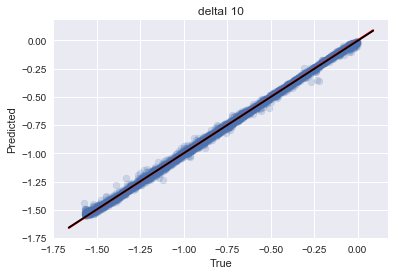

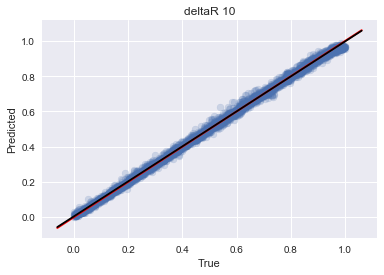

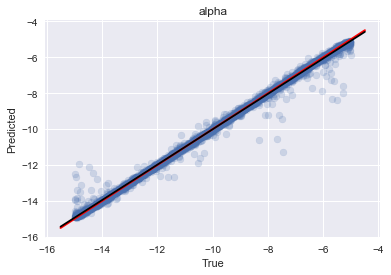

In [12]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0M_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_alpha_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0M_model_RF2_dr_sp = E0M_regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0M_model_RF2_di_sp = E0M_regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
E0M_model_RF2_alpha_sp = E0M_regr_RF2_alpha_sp.fit(X1_train, Y1_train['alpha'])

E0M_predictions_RF2_dr_sp = E0M_model_RF2_dr_sp.predict(X1_test)
E0M_predictions_RF2_di_sp = E0M_model_RF2_di_sp.predict(X1_test)
E0M_predictions_RF2_alpha_sp = E0M_model_RF2_alpha_sp.predict(X1_test)

E0M_scores_RF2 = [r2_score(Y1_test['deltaI'], E0M_predictions_RF2_di_sp), 
              r2_score(Y1_test['deltaR'], E0M_predictions_RF2_dr_sp), 
              r2_score(Y1_test['alpha'], E0M_predictions_RF2_alpha_sp)]

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

plotSummary(Y1_test['deltaR'], E0M_predictions_RF2_dr_sp, 'deltaI 10')
plotSummary(Y1_test['deltaI'], E0M_predictions_RF2_di_sp, 'deltaR 10')
plotSummary(Y1_test['alpha'], E0M_predictions_RF2_alpha_sp, 'alpha')


### peak info

 
RMSE on test data: 0.04699213891702775 for  deltaI 10
R^2 Score on test data: 0.9890679333329492 for deltaI 10
 
RMSE on test data: 0.025774714218543406 for  deltaR 10
R^2 Score on test data: 0.9920877152430593 for deltaR 10
 
RMSE on test data: 0.446379954706011 for  alpha
R^2 Score on test data: 0.9758667805963387 for alpha


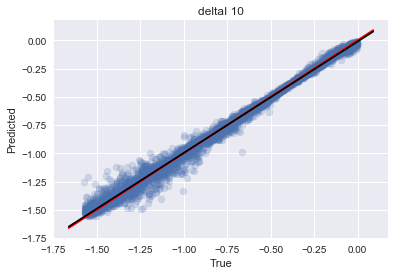

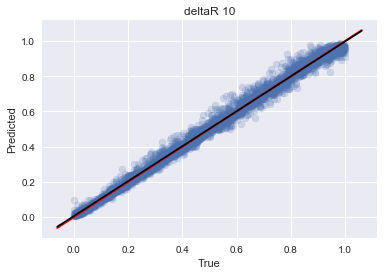

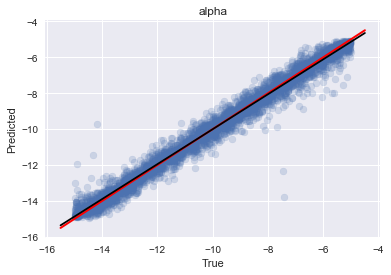

In [13]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0M_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_alpha_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0M_model_RF2_dr_pi = E0M_regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0M_model_RF2_di_pi = E0M_regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
E0M_model_RF2_alpha_pi = E0M_regr_RF2_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0M_predictions_RF2_dr_pi = E0M_model_RF2_dr_pi.predict(X2_test)
E0M_predictions_RF2_di_pi = E0M_model_RF2_di_pi.predict(X2_test)
E0M_predictions_RF2_alpha_pi = E0M_model_RF2_alpha_pi.predict(X2_test)

E0M_scores_RF2_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_RF2_di_pi), 
                 r2_score(Y2_test['deltaR'], E0M_predictions_RF2_dr_pi), 
                 r2_score(Y2_test['alpha'], E0M_predictions_RF2_alpha_pi)]

plotSummary(Y2_test['deltaR'], E0M_predictions_RF2_dr_pi, 'deltaI 10')
plotSummary(Y2_test['deltaI'], E0M_predictions_RF2_di_pi, 'deltaR 10')
plotSummary(Y2_test['alpha'], E0M_predictions_RF2_alpha_pi, 'alpha')

### spec points and peak info

 
RMSE on test data: 0.02417501063722689 for  deltaI 10
R^2 Score on test data: 0.9971067551208592 for deltaI 10
 
RMSE on test data: 0.015202831033850653 for  deltaR 10
R^2 Score on test data: 0.9972472730870715 for deltaR 10
 
RMSE on test data: 0.24283217300328488 for  alpha
R^2 Score on test data: 0.9928580246644273 for alpha


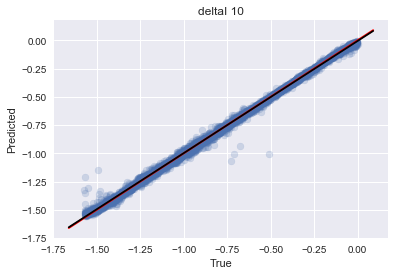

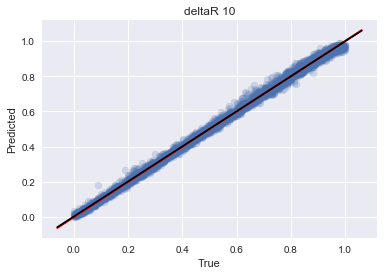

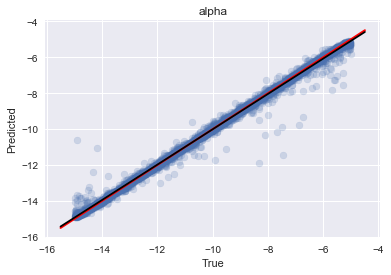

In [14]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0M_regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0M_regr_RF2_alpha_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0M_model_RF2_dr_both = E0M_regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
E0M_model_RF2_di_both = E0M_regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
E0M_model_RF2_alpha_both = E0M_regr_RF2_alpha_both.fit(X_train, Y_train['alpha'])

E0M_predictions_RF2_dr_both = E0M_model_RF2_dr_both.predict(X_test)
E0M_predictions_RF2_di_both = E0M_model_RF2_di_both.predict(X_test)
E0M_predictions_RF2_alpha_both = E0M_model_RF2_alpha_both.predict(X_test)

E0M_scores_RF2_both = [r2_score(Y_test['deltaI'], E0M_predictions_RF2_di_both), 
                 r2_score(Y_test['deltaR'], E0M_predictions_RF2_dr_both), 
                 r2_score(Y_test['alpha'], E0M_predictions_RF2_alpha_both)]

plotSummary(Y_test['deltaR'], E0M_predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], E0M_predictions_RF2_di_both, 'deltaR 10')
plotSummary(Y_test['alpha'], E0M_predictions_RF2_alpha_both, 'alpha')

## AdaBoost Random Forest

### spec points 

 
RMSE on test data: 0.015363390027004197 for  AdaBoost Delta I
R^2 Score on test data: 0.9971888222712426 for AdaBoost Delta I
 
RMSE on test data: 0.017864090141915395 for  AdaBoost Delta R
R^2 Score on test data: 0.9984201580250486 for AdaBoost Delta R
 
RMSE on test data: 0.19043851765092734 for  AdaBoost alpha
R^2 Score on test data: 0.9956074624953283 for AdaBoost alpha


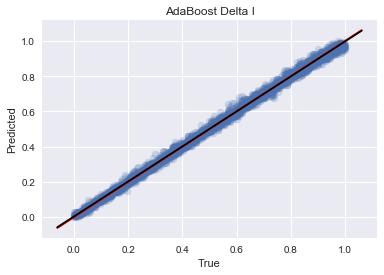

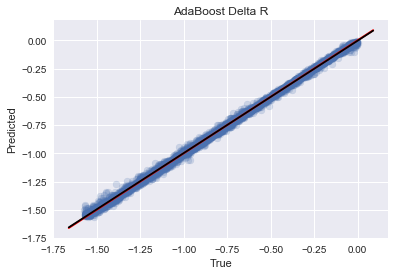

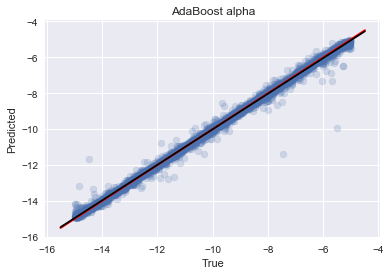

In [15]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0M_regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0M_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0M_regr_AB_alpha_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0M_model_AB_di_sp = E0M_regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0M_model_AB_dr_sp = E0M_regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0M_model_AB_alpha_sp = E0M_regr_AB_alpha_sp.fit(X1_train, Y1_train['alpha'])

E0M_predictions_AB_di_sp = E0M_model_AB_di_sp.predict(X1_test)
E0M_predictions_AB_dr_sp = E0M_model_AB_dr_sp.predict(X1_test)
E0M_predictions_AB_alpha_sp = E0M_model_AB_alpha_sp.predict(X1_test)

E0M_scores_AB = [r2_score(Y1_test['deltaI'], E0M_predictions_AB_di_sp), 
             r2_score(Y1_test['deltaR'], E0M_predictions_AB_dr_sp), 
             r2_score(Y1_test['alpha'], E0M_predictions_AB_alpha_sp)]

plotSummary(Y1_test['deltaI'], E0M_predictions_AB_di_sp, 'AdaBoost Delta I')
plotSummary(Y1_test['deltaR'], E0M_predictions_AB_dr_sp, 'AdaBoost Delta R')
plotSummary(Y1_test['alpha'], E0M_predictions_AB_alpha_sp, 'AdaBoost alpha')




### peak info

 
RMSE on test data: 0.027541930731600238 for  AdaBoost Delta I
R^2 Score on test data: 0.9909655242846503 for AdaBoost Delta I
 
RMSE on test data: 0.04970024588719798 for  AdaBoost Delta R
R^2 Score on test data: 0.9877716201664587 for AdaBoost Delta R
 
RMSE on test data: 0.4978899796248963 for  AdaBoost alpha
R^2 Score on test data: 0.969975715583627 for AdaBoost alpha


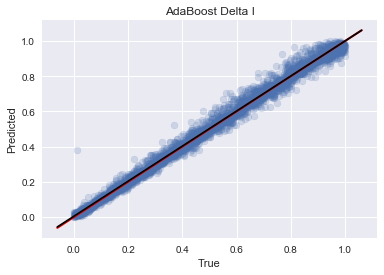

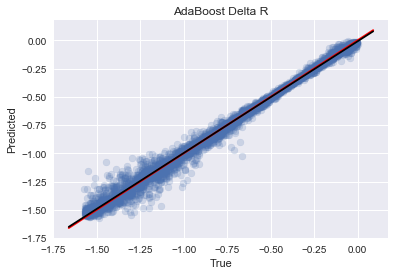

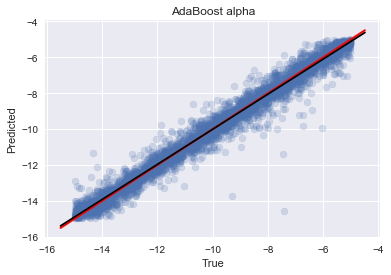

In [16]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0M_regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0M_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0M_regr_AB_alpha_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0M_model_AB_di_pi = E0M_regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0M_model_AB_dr_pi = E0M_regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0M_model_AB_alpha_pi = E0M_regr_AB_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0M_predictions_AB_di_pi = E0M_model_AB_di_pi.predict(X2_test)
E0M_predictions_AB_dr_pi = E0M_model_AB_dr_pi.predict(X2_test)
E0M_predictions_AB_alpha_pi = E0M_model_AB_alpha_pi.predict(X2_test)

E0M_scores_AB_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_AB_di_pi), 
                r2_score(Y2_test['deltaR'], E0M_predictions_AB_dr_pi), 
                r2_score(Y2_test['alpha'], E0M_predictions_AB_alpha_pi)]

plotSummary(Y2_test['deltaI'], E0M_predictions_AB_di_pi, 'AdaBoost Delta I')
plotSummary(Y2_test['deltaR'], E0M_predictions_AB_dr_pi, 'AdaBoost Delta R')
plotSummary(Y2_test['alpha'], E0M_predictions_AB_alpha_pi, 'AdaBoost alpha')


### spec points and peak info

 
RMSE on test data: 0.016322115627483272 for  AdaBoost Delta I
R^2 Score on test data: 0.9968270217751679 for AdaBoost Delta I
 
RMSE on test data: 0.02097923875788249 for  AdaBoost Delta R
R^2 Score on test data: 0.9978211301142084 for AdaBoost Delta R
 
RMSE on test data: 0.19625438141658788 for  AdaBoost alpha
R^2 Score on test data: 0.9953350755335604 for AdaBoost alpha


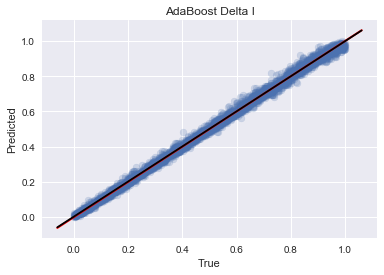

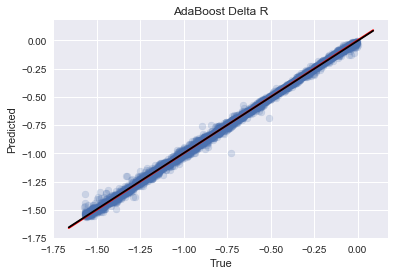

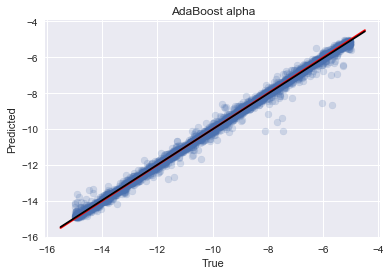

In [17]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0M_regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0M_regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0M_regr_AB_alpha_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0M_model_AB_di_both = E0M_regr_AB_di_both.fit(X_train, Y_train['deltaI'])
E0M_model_AB_dr_both = E0M_regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
E0M_model_AB_alpha_both = E0M_regr_AB_alpha_both.fit(X_train, Y_train['alpha'])

E0M_predictions_AB_di_both = E0M_model_AB_di_both.predict(X_test)
E0M_predictions_AB_dr_both = E0M_model_AB_dr_both.predict(X_test)
E0M_predictions_AB_alpha_both = E0M_model_AB_alpha_both.predict(X_test)

E0M_scores_AB_both = [r2_score(Y_test['deltaI'], E0M_predictions_AB_di_both), 
                r2_score(Y_test['deltaR'], E0M_predictions_AB_dr_both), 
                r2_score(Y_test['alpha'], E0M_predictions_AB_alpha_both)]

plotSummary(Y_test['deltaI'], E0M_predictions_AB_di_both, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], E0M_predictions_AB_dr_both, 'AdaBoost Delta R')
plotSummary(Y_test['alpha'], E0M_predictions_AB_alpha_both, 'AdaBoost alpha')



## Gradient Boosting Random Forests

### spec points

 
RMSE on test data: 0.026889520906095404 for  GradientBoost Delta I
R^2 Score on test data: 0.9913884699722435 for GradientBoost Delta I
 
RMSE on test data: 0.03317184583242794 for  GradientBoost Delta R
R^2 Score on test data: 0.9945525767253652 for GradientBoost Delta R
 
RMSE on test data: 0.32682374723039354 for  GradientBoost alpha
R^2 Score on test data: 0.9870630141264208 for GradientBoost alpha


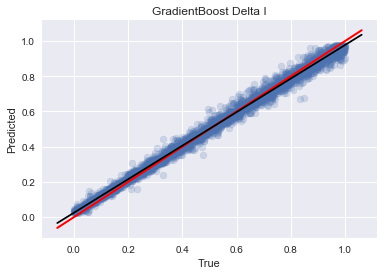

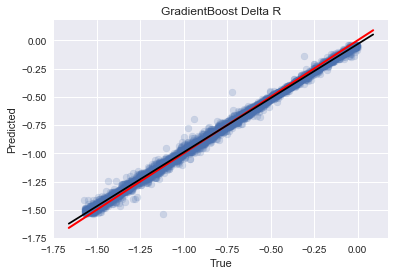

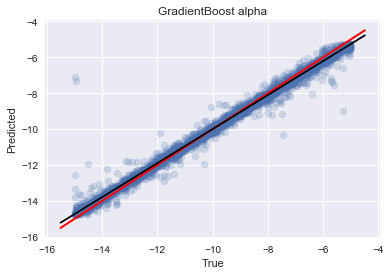

In [18]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0M_regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_alpha_sp = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0M_model_GB_di_sp = E0M_regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0M_model_GB_dr_sp = E0M_regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0M_model_GB_alpha_sp = E0M_regr_GB_alpha_sp.fit(X1_train, Y1_train['alpha'])


E0M_predictions_GB_di_sp = E0M_model_GB_di_sp.predict(X1_test)
E0M_predictions_GB_dr_sp = E0M_model_GB_dr_sp.predict(X1_test)
E0M_predictions_GB_alpha_sp = E0M_model_GB_alpha_sp.predict(X1_test)

E0M_scores_GB = [r2_score(Y1_test['deltaI'], E0M_predictions_GB_di_sp), 
                r2_score(Y1_test['deltaR'], E0M_predictions_GB_dr_sp), 
                r2_score(Y1_test['alpha'], E0M_predictions_GB_alpha_sp)]

plotSummary(Y1_test['deltaI'], E0M_predictions_GB_di_sp, 'GradientBoost Delta I')
plotSummary(Y1_test['deltaR'], E0M_predictions_GB_dr_sp, 'GradientBoost Delta R')
plotSummary(Y1_test['alpha'], E0M_predictions_GB_alpha_sp, 'GradientBoost alpha')


### peak info

 
RMSE on test data: 0.03526460544310738 for  GradientBoost Delta I
R^2 Score on test data: 0.9851887316791644 for GradientBoost Delta I
 
RMSE on test data: 0.05802271523150172 for  GradientBoost Delta R
R^2 Score on test data: 0.9833333643341655 for GradientBoost Delta R
 
RMSE on test data: 0.5288613289293475 for  GradientBoost alpha
R^2 Score on test data: 0.9661242033202279 for GradientBoost alpha


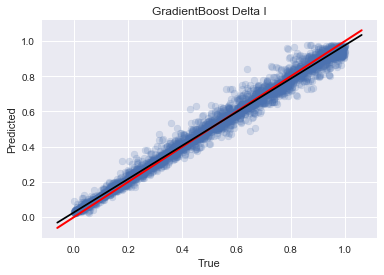

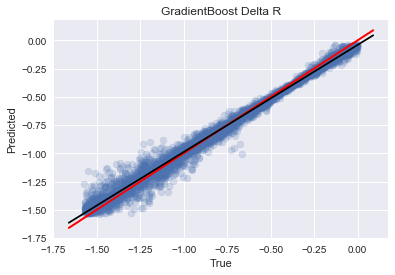

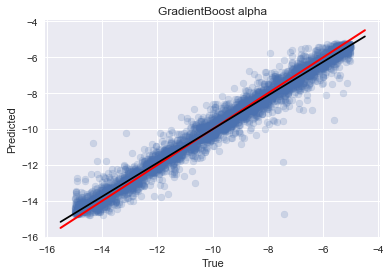

In [19]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0M_regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_alpha_pi = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0M_model_GB_di_pi = E0M_regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0M_model_GB_dr_pi = E0M_regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0M_model_GB_alpha_pi = E0M_regr_GB_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0M_predictions_GB_di_pi = E0M_model_GB_di_pi.predict(X2_test)
E0M_predictions_GB_dr_pi = E0M_model_GB_dr_pi.predict(X2_test)
E0M_predictions_GB_alpha_pi = E0M_model_GB_alpha_pi.predict(X2_test)

E0M_scores_GB_pi = [r2_score(Y2_test['deltaI'], E0M_predictions_GB_di_pi), 
                r2_score(Y2_test['deltaR'], E0M_predictions_GB_dr_pi), 
                r2_score(Y2_test['alpha'], E0M_predictions_GB_alpha_pi)]

plotSummary(Y2_test['deltaI'], E0M_predictions_GB_di_pi, 'GradientBoost Delta I')
plotSummary(Y2_test['deltaR'], E0M_predictions_GB_dr_pi, 'GradientBoost Delta R')
plotSummary(Y2_test['alpha'], E0M_predictions_GB_alpha_pi, 'GradientBoost alpha')



### spec points and peak info

 
RMSE on test data: 0.026171361070541438 for  GradientBoost Delta I
R^2 Score on test data: 0.9918423172854174 for GradientBoost Delta I
 
RMSE on test data: 0.03917000771262867 for  GradientBoost Delta R
R^2 Score on test data: 0.9924044511789564 for GradientBoost Delta R
 
RMSE on test data: 0.3523418575009358 for  GradientBoost alpha
R^2 Score on test data: 0.9849639288271775 for GradientBoost alpha


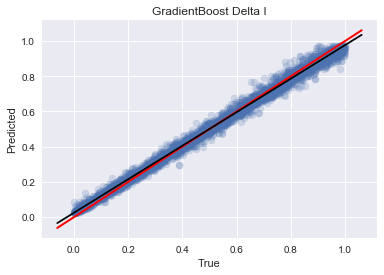

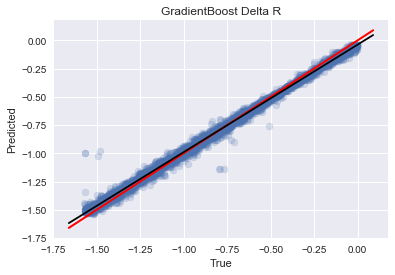

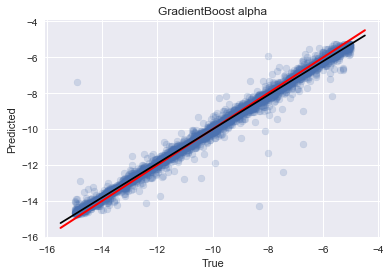

In [20]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0M_regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0M_regr_GB_alpha_both = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0M_model_GB_di_both = E0M_regr_GB_di_both.fit(X_train, Y_train['deltaI'])
E0M_model_GB_dr_both = E0M_regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
E0M_model_GB_alpha_both = E0M_regr_GB_alpha_both.fit(X_train, Y_train['alpha'])

E0M_predictions_GB_di_both = E0M_model_GB_di_both.predict(X_test)
E0M_predictions_GB_dr_both = E0M_model_GB_dr_both.predict(X_test)
E0M_predictions_GB_alpha_both = E0M_model_GB_alpha_both.predict(X_test)

E0M_scores_GB_both = [r2_score(Y_test['deltaI'], E0M_predictions_GB_di_both), 
                r2_score(Y_test['deltaR'], E0M_predictions_GB_dr_both), 
                r2_score(Y_test['alpha'], E0M_predictions_GB_alpha_both)]

plotSummary(Y_test['deltaI'], E0M_predictions_GB_di_both, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], E0M_predictions_GB_dr_both, 'GradientBoost Delta R')
plotSummary(Y_test['alpha'], E0M_predictions_GB_alpha_both, 'GradientBoost alpha')



## Testing on Experimental Data

In [21]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

col_names_exp_both = col_names_both[5:]
col_names_exp_pi = col_names2a[5:]
col_names_exp_a = col_names_a[5:]

exp_data_both = exp_data_sp.join(exp_data_pi, how = 'left')
exp_data_both = exp_data_both[col_names_exp_both]

exp_data_sp = exp_data_sp[col_names_exp_a]
exp_data_pi = exp_data_pi[col_names_exp_pi]

E0M_pred_phase_OLS_R_sp = E0M_results_OLS_R_sp.predict(exp_data_sp)
E0M_pred_phase_OLS_I_sp = E0M_results_OLS_I_sp.predict(exp_data_sp)
E0M_pred_phase_OLS_alpha_sp = E0M_results_OLS_alpha_sp.predict(exp_data_sp)

E0M_pred_phase_OLS_R_pi = E0M_results_OLS_R_pi.predict(exp_data_pi)
E0M_pred_phase_OLS_I_pi = E0M_results_OLS_I_pi.predict(exp_data_pi)
E0M_pred_phase_OLS_alpha_pi = E0M_results_OLS_alpha_pi.predict(exp_data_pi)

E0M_pred_phase_OLS_R_both = E0M_results_OLS_R_both.predict(exp_data_both)
E0M_pred_phase_OLS_I_both = E0M_results_OLS_I_both.predict(exp_data_both)
E0M_pred_phase_OLS_alpha_both = E0M_results_OLS_alpha_both.predict(exp_data_both)

E0M_phases_OLS_sp = [E0M_pred_phase_OLS_I_sp[0], 
                    E0M_pred_phase_OLS_R_pi[0], 
                    E0M_pred_phase_OLS_alpha_sp[0]]

E0M_phases_OLS_pi = [E0M_pred_phase_OLS_I_pi[0], 
                    E0M_pred_phase_OLS_R_pi[0], 
                    E0M_pred_phase_OLS_alpha_pi[0]]

E0M_phases_OLS_both = [E0M_pred_phase_OLS_I_both[0], 
                    E0M_pred_phase_OLS_R_both[0], 
                    E0M_pred_phase_OLS_alpha_both[0]]

#pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))
E0M_phases_DT_sp = E0M_regr_DT_sp.predict(exp_data_sp)
E0M_phases_DT_pi = E0M_regr_DT_pi.predict(exp_data_pi)
E0M_phases_DT_both = E0M_regr_DT_both.predict(exp_data_both)

E0M_phases_RF_sp = E0M_regr_RF_sp.predict(exp_data_sp)
E0M_phases_RF_pi = E0M_regr_RF_pi.predict(exp_data_pi)
E0M_phases_RF_both = E0M_regr_RF_both.predict(exp_data_both)

E0M_pred_phase_AB_R_sp = E0M_model_AB_dr_sp.predict(exp_data_sp)
E0M_pred_phase_AB_I_sp = E0M_model_AB_di_sp.predict(exp_data_sp)
E0M_pred_phase_AB_alpha_sp = E0M_model_AB_alpha_sp.predict(exp_data_sp)

E0M_pred_phase_AB_R_pi = E0M_model_AB_dr_pi.predict(exp_data_pi)
E0M_pred_phase_AB_I_pi = E0M_model_AB_di_pi.predict(exp_data_pi)
E0M_pred_phase_AB_alpha_pi = E0M_model_AB_alpha_pi.predict(exp_data_pi)

E0M_pred_phase_AB_R_both = E0M_model_AB_dr_both.predict(exp_data_both)
E0M_pred_phase_AB_I_both = E0M_model_AB_di_both.predict(exp_data_both)
E0M_pred_phase_AB_alpha_both = E0M_model_AB_alpha_both.predict(exp_data_both)

E0M_phases_AB_sp = [E0M_pred_phase_AB_I_sp[0], 
                   E0M_pred_phase_AB_R_sp[0], 
                   E0M_pred_phase_AB_alpha_sp[0]]

E0M_phases_AB_pi = [E0M_pred_phase_AB_I_pi[0], 
                   E0M_pred_phase_AB_R_pi[0], 
                   E0M_pred_phase_AB_alpha_pi[0]]

E0M_phases_AB_both = [E0M_pred_phase_AB_I_both[0], 
                   E0M_pred_phase_AB_R_both[0], 
                   E0M_pred_phase_AB_alpha_both[0]]

E0M_pred_phase_GB_di_sp = E0M_model_GB_di_sp.predict(exp_data_sp)
E0M_pred_phase_GB_dr_sp = E0M_model_GB_dr_sp.predict(exp_data_sp)
E0M_pred_phase_GB_alpha_sp = E0M_model_GB_alpha_sp.predict(exp_data_sp)

E0M_pred_phase_GB_di_pi = E0M_model_GB_di_pi.predict(exp_data_pi)
E0M_pred_phase_GB_dr_pi = E0M_model_GB_dr_pi.predict(exp_data_pi)
E0M_pred_phase_GB_alpha_pi = E0M_model_GB_alpha_pi.predict(exp_data_pi)

E0M_pred_phase_GB_di_both = E0M_model_GB_di_both.predict(exp_data_both)
E0M_pred_phase_GB_dr_both = E0M_model_GB_dr_both.predict(exp_data_both)
E0M_pred_phase_GB_alpha_both = E0M_model_GB_alpha_both.predict(exp_data_both)

E0M_phases_GB_sp = [E0M_pred_phase_GB_di_sp[0], 
                   E0M_pred_phase_GB_dr_sp[0], 
                   E0M_pred_phase_GB_alpha_sp[0]]

E0M_phases_GB_pi = [E0M_pred_phase_GB_di_pi[0], 
                   E0M_pred_phase_GB_dr_pi[0], 
                   E0M_pred_phase_GB_alpha_pi[0]]

E0M_phases_GB_both = [E0M_pred_phase_GB_di_both[0], 
                   E0M_pred_phase_GB_dr_both[0], 
                   E0M_pred_phase_GB_alpha_both[0]]

E0M_pred_phase_IRF_di_sp = E0M_model_RF2_di_sp.predict(exp_data_sp)
E0M_pred_phase_IRF_dr_sp = E0M_model_RF2_dr_sp.predict(exp_data_sp)
E0M_pred_phase_IRF_alpha_sp = E0M_model_RF2_alpha_sp.predict(exp_data_sp)

E0M_pred_phase_IRF_di_pi = E0M_model_RF2_di_pi.predict(exp_data_pi)
E0M_pred_phase_IRF_dr_pi = E0M_model_RF2_dr_pi.predict(exp_data_pi)
E0M_pred_phase_IRF_alpha_pi = E0M_model_RF2_alpha_pi.predict(exp_data_pi)

E0M_pred_phase_IRF_di_both = E0M_model_RF2_di_both.predict(exp_data_both)
E0M_pred_phase_IRF_dr_both = E0M_model_RF2_dr_both.predict(exp_data_both)
E0M_pred_phase_IRF_alpha_both = E0M_model_RF2_alpha_both.predict(exp_data_both)

E0M_phases_IRF_sp = [E0M_pred_phase_IRF_di_sp[0], 
                    E0M_pred_phase_IRF_dr_sp[0], 
                    E0M_pred_phase_IRF_alpha_sp[0]]

E0M_phases_IRF_pi = [E0M_pred_phase_IRF_di_pi[0], 
                    E0M_pred_phase_IRF_dr_pi[0], 
                    E0M_pred_phase_IRF_alpha_pi[0]]

E0M_phases_IRF_both = [E0M_pred_phase_IRF_di_both[0], 
                    E0M_pred_phase_IRF_dr_both[0], 
                    E0M_pred_phase_IRF_alpha_both[0]]

E0M_predictedPhases = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'alpha'])

E0M_predictedPhases.loc['OLS_sp'] = E0M_phases_OLS_sp
E0M_predictedPhases.loc['OLS_pi'] = E0M_phases_OLS_pi
E0M_predictedPhases.loc['OLS_both'] = E0M_phases_OLS_both
E0M_predictedPhases.loc['DT_sp'] = E0M_phases_DT_sp.tolist()[0]
E0M_predictedPhases.loc['DT_pi'] = E0M_phases_DT_pi.tolist()[0]
E0M_predictedPhases.loc['DT_both'] = E0M_phases_DT_both.tolist()[0]
E0M_predictedPhases.loc['RF_sp'] = E0M_phases_RF_sp.tolist()[0]
E0M_predictedPhases.loc['RF_pi'] = E0M_phases_RF_pi.tolist()[0]
E0M_predictedPhases.loc['RF_both'] = E0M_phases_RF_both.tolist()[0]
E0M_predictedPhases.loc['IRF_sp'] = E0M_phases_IRF_sp
E0M_predictedPhases.loc['IRF_pi'] = E0M_phases_IRF_pi
E0M_predictedPhases.loc['IRF_both'] = E0M_phases_IRF_both
E0M_predictedPhases.loc['AB_sp'] = E0M_phases_AB_sp
E0M_predictedPhases.loc['AB_pi'] = E0M_phases_AB_pi
E0M_predictedPhases.loc['AB_both'] = E0M_phases_AB_both
E0M_predictedPhases.loc['GB_sp'] = E0M_phases_GB_sp
E0M_predictedPhases.loc['GB_pi'] = E0M_phases_GB_pi
E0M_predictedPhases.loc['GB_both'] = E0M_phases_GB_both

E0M_Scores = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'alpha'])

E0M_Scores.loc['OLS_sp'] = E0M_scores_OLS
E0M_Scores.loc['OLS_pi'] = E0M_scores_OLS_pi
E0M_Scores.loc['OLS_both'] = E0M_scores_OLS_both
E0M_Scores.loc['DT_sp'] = E0M_scores_DT
E0M_Scores.loc['DT_pi'] = E0M_scores_DT_pi
E0M_Scores.loc['DT_both'] = E0M_scores_DT_both
E0M_Scores.loc['RF_sp'] = E0M_scores_RF
E0M_Scores.loc['RF_pi'] = E0M_scores_RF_pi
E0M_Scores.loc['RF_both'] = E0M_scores_RF_both
E0M_Scores.loc['IRF_sp'] = E0M_scores_RF2
E0M_Scores.loc['IRF_pi'] = E0M_scores_RF2_pi
E0M_Scores.loc['IRF_both'] = E0M_scores_RF2_both
E0M_Scores.loc['AB_sp'] = E0M_scores_AB
E0M_Scores.loc['AB_pi'] = E0M_scores_AB_pi
E0M_Scores.loc['AB_both'] = E0M_scores_AB_both
E0M_Scores.loc['GB_sp'] = E0M_scores_GB
E0M_Scores.loc['GB_pi'] = E0M_scores_GB_pi
E0M_Scores.loc['GB_both'] = E0M_scores_GB_both

E0M_Scores

,deltaI,deltaR,alpha
OLS_sp,-18.541042,-13.773090,0.622993
OLS_pi,0.740513,0.330623,0.587468
OLS_both,0.832963,0.909696,0.964390
DT_sp,0.955595,0.972650,0.987223
DT_pi,0.970740,0.976641,0.966131
DT_both,0.958573,0.973149,0.980602
RF_sp,0.993536,0.996715,0.994232
RF_pi,0.985633,0.983445,0.975909
RF_both,0.993544,0.995956,0.991700
IRF_sp,0.997816,0.998750,0.994202


In [27]:
score_threshold = 0.95

avgalpha = E0M_predictedPhases[E0M_Scores > score_threshold].drop(['OLS_both'], axis = 0)['alpha'].mean()

avgalpha

-12.3527005623108

In [26]:
E0M_predictedPhases[E0M_Scores>score_threshold]

,deltaI,deltaR,alpha
OLS_sp,NaN,NaN,NaN
OLS_pi,NaN,NaN,NaN
OLS_both,NaN,NaN,-13.236657
DT_sp,0.305523,-0.125287,-12.476000
DT_pi,0.402845,-0.221410,-12.048000
DT_both,0.439650,-0.115170,-13.068000
RF_sp,0.321150,-0.164390,-12.317593
RF_pi,0.316182,-0.138868,-12.253333
RF_both,0.317934,-0.214366,-12.426000
IRF_sp,0.202924,-0.113311,-12.860850


In [24]:
#save_data = True
if save_data == True:
    E0M_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_threekinds_E0Mfixed_limitallrange300_removepeak1prom1.csv')
    E0M_Scores.to_csv('Model_Results/Hexagon/scores_v7_threekinds_E0Mfixed_limitallrange300_removepeak1prom1.csv')